In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt



In [ ]:
dataset_paths = [
    "/content/drive/MyDrive/cards2/train",
    "/content/drive/MyDrive/cards2/test",
    "/content/drive/MyDrive/cards2/valid"
]

# HOG parameters
hog_params = {
    'orientations': 9,              # Adjust as needed for finer gradient capture
    'pixels_per_cell': (8,8),      # Set to capture smaller image details
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys'
}

# Image size for consistency
image_size = (260, 260)

# Lists to hold features and labels
data = []
labels = []

# Load and preprocess images from all dataset folders
for dataset_path in dataset_paths:
    for class_name in os.listdir(dataset_path):
        class_folder_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_folder_path):
            continue  # Skip non-directories

        for image_name in os.listdir(class_folder_path):
            if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            # Load, resize, and extract HOG features
            image_path = os.path.join(class_folder_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue
            image_resized = cv2.resize(image, image_size)
            hog_features = hog(image_resized, **hog_params)

            # Append features and class label
            data.append(hog_features)
            labels.append(class_name)

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

In [ ]:
# Train SVM model on HOG features
svm_clf = SVC(kernel='linear', C=1.0, gamma='scale')  # Using linear kernel for simplicity
svm_clf.fit(X_train, y_train)

# Save the SVM model and label encoder
with open('hog_svm_model.pkl', 'wb') as file:
    pickle.dump(svm_clf, file)
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [ ]:
# Evaluate the model
y_pred = svm_clf.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# Calculate metrics
accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted', zero_division=1)
recall = recall_score(y_test_labels, y_pred_labels, average='weighted', zero_division=1)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels, zero_division=1))

Accuracy: 59.91%
Precision: 65.74%
Recall: 59.91%
Classification Report:
                    precision    recall  f1-score   support

     ace of clubs       0.67      0.67      0.67        15
  ace of diamonds       0.92      0.57      0.71        21
    ace of hearts       0.50      0.77      0.61        13
    ace of spades       0.57      0.57      0.57        14
   eight of clubs       0.22      0.43      0.29        14
eight of diamonds       0.60      0.60      0.60        15
  eight of hearts       0.71      0.50      0.59        10
  eight of spades       0.83      0.56      0.67        18
    five of clubs       1.00      0.78      0.88        18
 five of diamonds       0.75      0.30      0.43        10
   five of hearts       0.64      0.78      0.70         9
   five of spades       0.73      0.67      0.70        12
    four of clubs       0.31      0.62      0.42         8
 four of diamonds       0.40      0.86      0.55         7
   four of hearts       0.29      0.29  

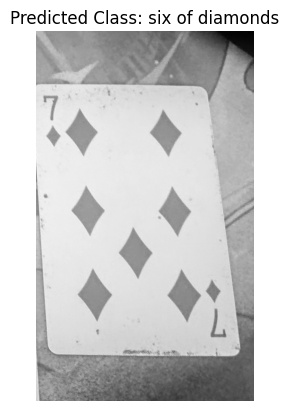

Predicted class for the new image: None


In [ ]:
def predict_image(image_path, model, encoder, hog_params):
    # Load and preprocess the new image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_resized = cv2.resize(image, image_size)  # Ensure resizing to training size
    features = hog(image_resized, **hog_params).reshape(1, -1)

    # Predict using the SVM model
    encoded_prediction = model.predict(features)
    prediction = encoder.inverse_transform(encoded_prediction)[0]

    # Plot the image with the prediction
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted Class: {prediction}")
    plt.axis('off')  # Hide axis for a cleaner look
    plt.show()

# Load the saved SVM model and label encoder for prediction
with open('hog_svm_model.pkl', 'rb') as file:
    svm_clf = pickle.load(file)
with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

# Example usage of prediction and plotting on a new image
new_image_path = '/content/7diamond.jpg'
predicted_class = predict_image(new_image_path, svm_clf, label_encoder, hog_params)
print(f"Predicted class for the new image: {predicted_class}")